In [1]:
from torch_snippets import *
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader


data_folder = 'CARD 20'
datasets.CIFAR10(data_folder, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: CARD 20
    Split: Train

In [3]:
class Colorize(datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root, train)

    def __getitem__(self, ix):
        im, _ = super().__getitem__(ix)
        bw = im.convert('L').convert('RGB')
        bw, im = np.array(bw) / 255, np.array(im) / 255
        bw, im = [torch.tensor(i).permute(2, 0, 1).to(device).float() for i in [bw, im]]

        return bw, im

trn_ds = Colorize(data_folder, train=True)
val_ds = Colorize(data_folder, train=False)

trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True)

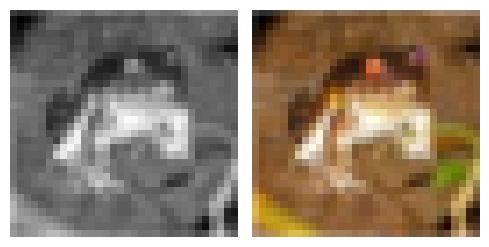

In [4]:
a, b = trn_ds[0]
subplots([a,b], nc = 2)

In [5]:
import torch
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class DownConv(nn.Module):
    def __init__(self, ni, no, maxpool = True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),

            nn.Conv2d(ni, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.model(x)

class UpConv(nn.Module):
    def __init__(self, ni, no, maxpool = True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni, no, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x, y], axis=1)
        x = self.convlayers(x)

        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DownConv(3, 64, maxpool=False)
        self.down2 = DownConv(64, 128)
        self.down3 = DownConv(128, 256)
        self.down4 = DownConv(256, 512)
        self.down5 = DownConv(512, 1024)

        self.up1 = UpConv(1024, 512)
        self.up2 = UpConv(512, 256)
        self.up3 = UpConv(256, 128)
        self.up4 = UpConv(128, 64)

        self.out = nn.Conv2d(64, 3, 1, 1)

    def forward(self, x):
        # down
        x0 = self.down1(x)
        x1 = self.down2(x0)
        x2 = self.down3(x1)
        x3 = self.down4(x2)
        x4 = self.down5(x3)

        # up - tive que alterar o que sai da função
        x4 = self.up1(x4, x3)
        x3 = self.up2(x4, x2)
        x2 = self.up3(x3, x1)
        x1 = self.up4(x2, x0)

        out = self.out(x1)

        return out

In [6]:
import torch.optim as optim

def get_model():
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    return model, optimizer, loss_fn

def train_batch(model, data, optimizer, criterion):
    model.train()
    x, y = data
    # mandar pro lugar certo
    x, y = x.to(device), y.to(device)

    # forward
    _y = model(x)

    # loss
    optimizer.zero_grad()
    loss = criterion(_y, y)

    # backward
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate_branch(model, data, criterion):
    model.eval()
    x, y = data
    _y = model(x)
    loss = criterion(_y, y)

    return loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08212035..1.4170216].


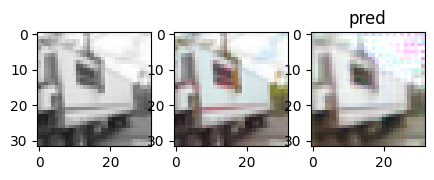

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11210143..1.0415543].


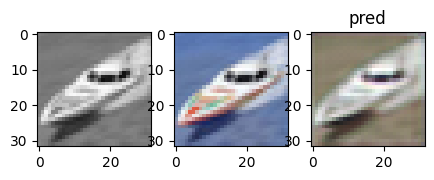

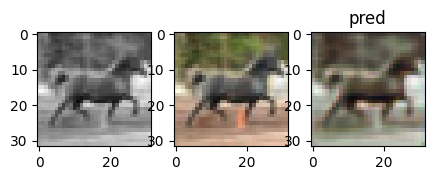

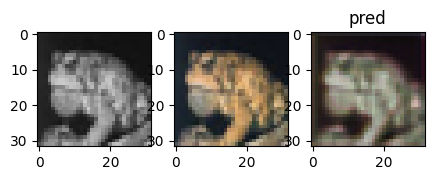

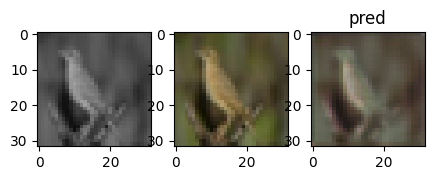

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04160059..1.0078146].


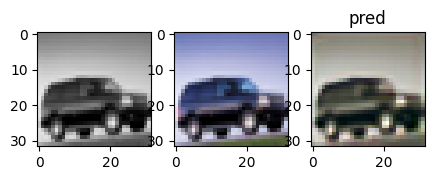

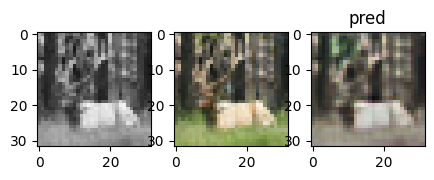

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08672886..0.9980433].


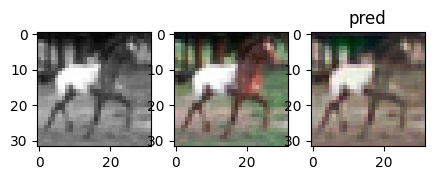

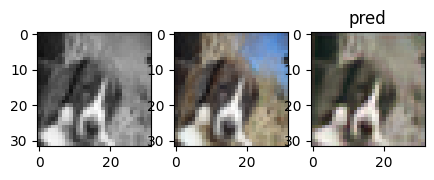

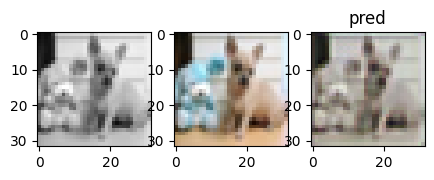

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03373495..1.1069045].


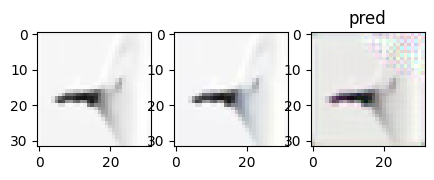

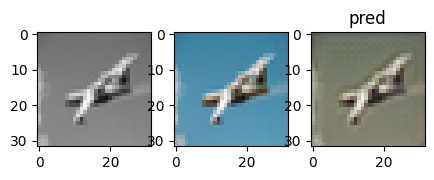

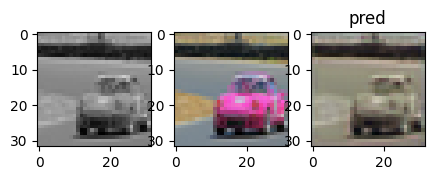

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.112113915..1.0080822].


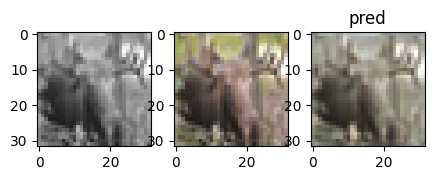

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0020336478..0.8948507].


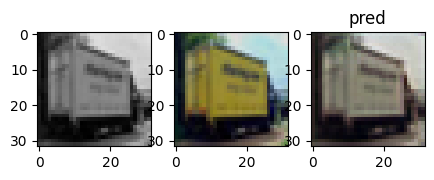

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023005525..0.9424894].


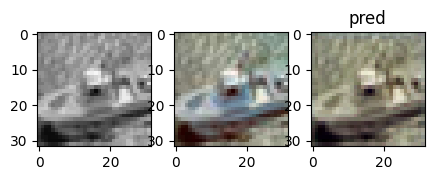

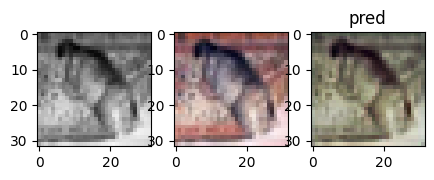

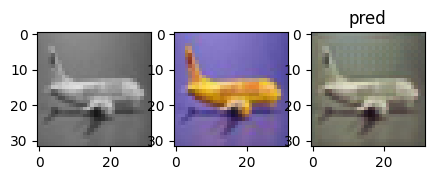

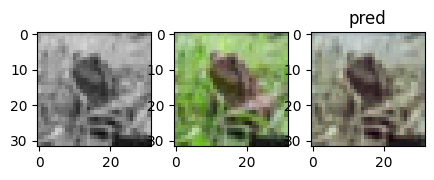

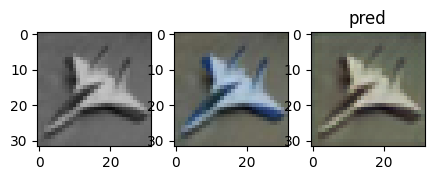

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07794198..0.99544656].


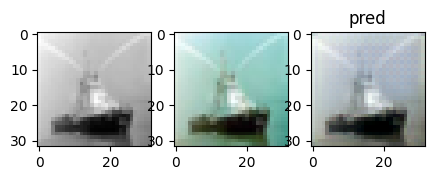

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.23522101..1.0609063].


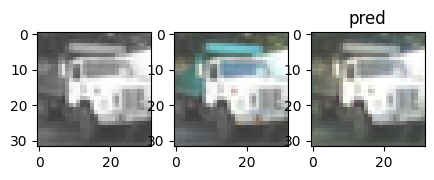

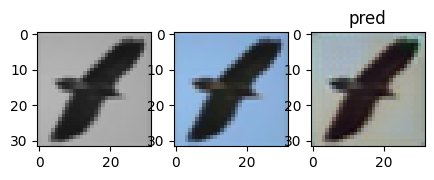

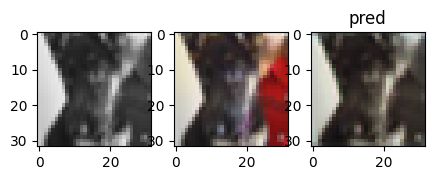

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0002207081..1.0886567].


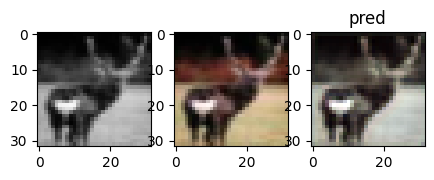

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.049060937..0.9296137].


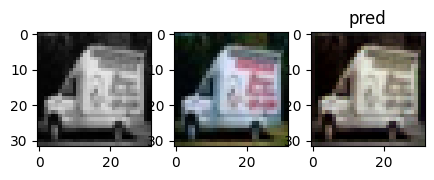

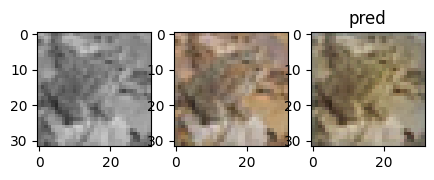

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02956603..1.0199564].


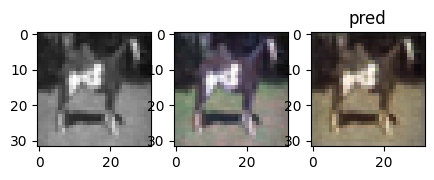

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08376757..1.0762801].


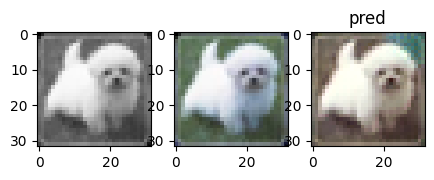

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050824832..1.0632572].


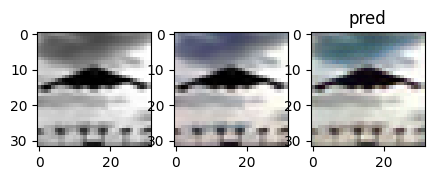

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010778907..1.1247371].


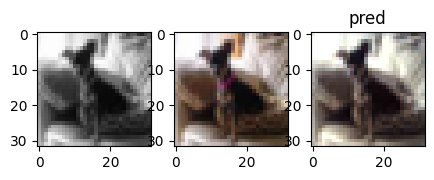

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10569065..1.0067585].


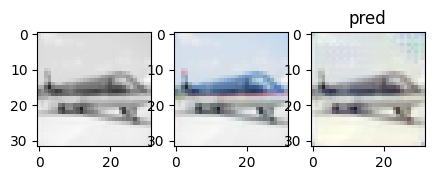

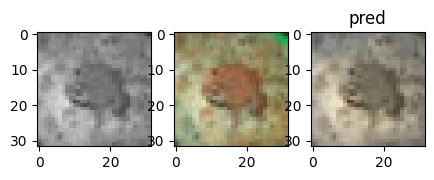

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.058666468..1.070373].


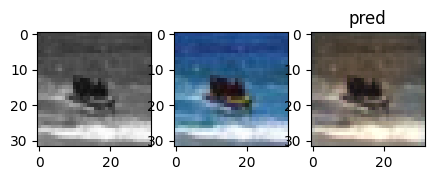

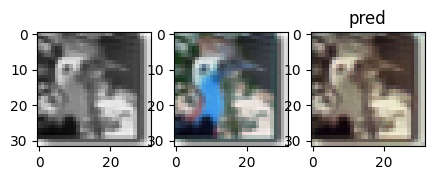

avg: 1/22 Batch 79/79 Loss 0.004068
loss: 0.0057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0563231..1.0081012].


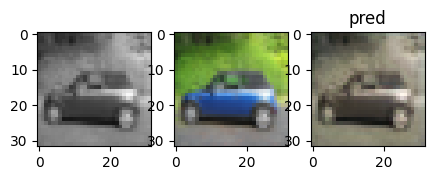

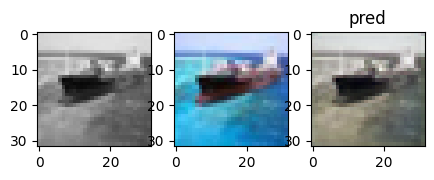

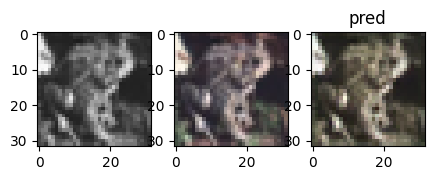

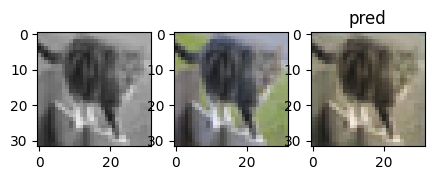

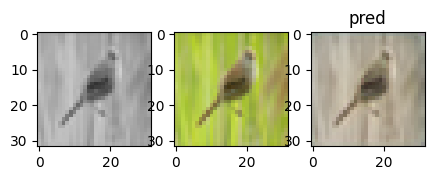

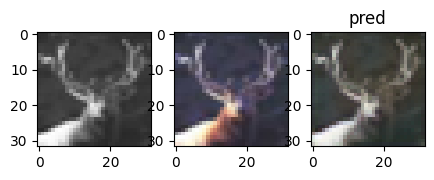

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.062099833..1.1025478].


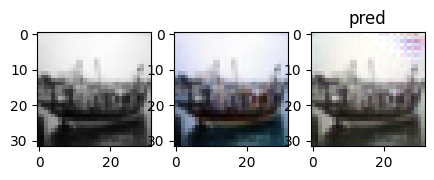

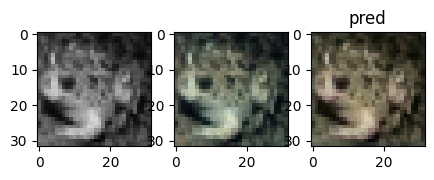

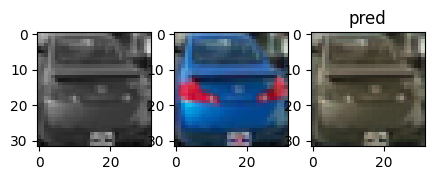

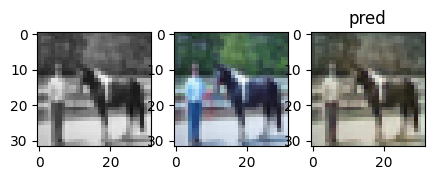

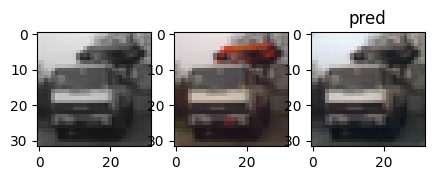

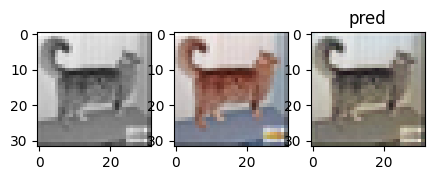

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054084975..1.0150168].


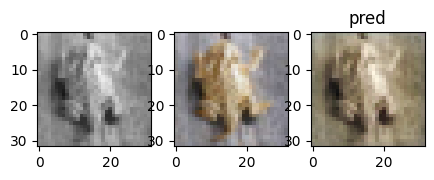

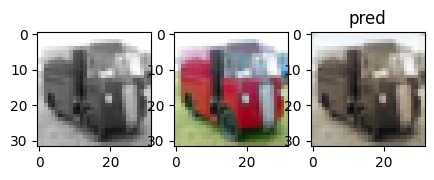

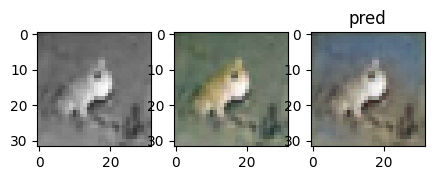

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12807786..1.0917877].


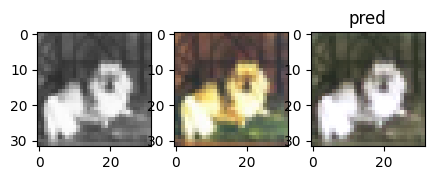

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04581157..1.0078294].


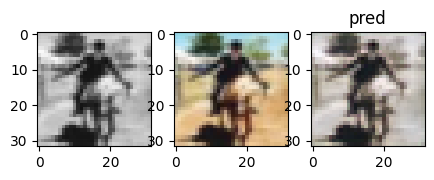

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01746358..1.2144951].


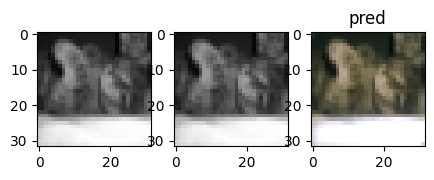

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06160964..1.0012044].


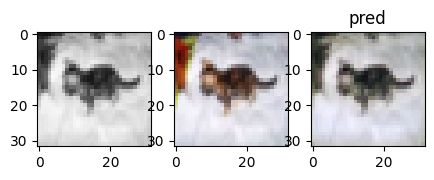

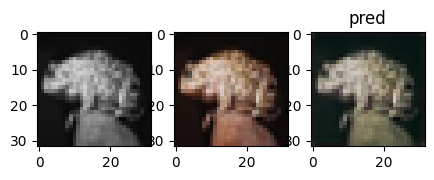

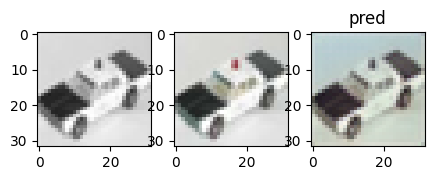

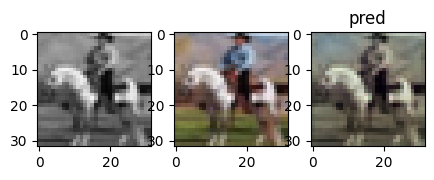

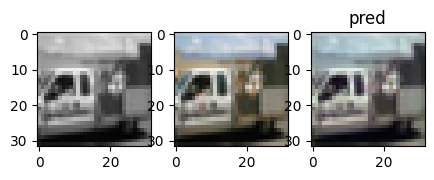

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06456723..1.0858505].


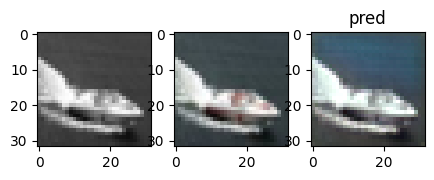

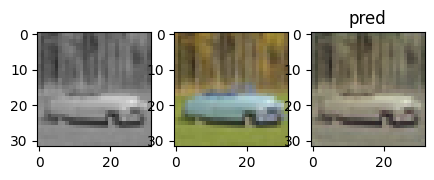

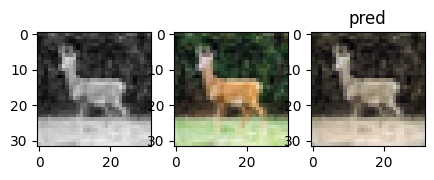

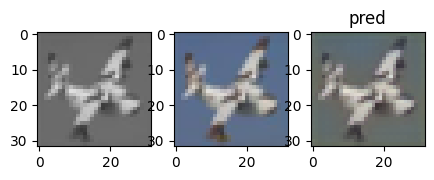

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.072586074..1.0096574].


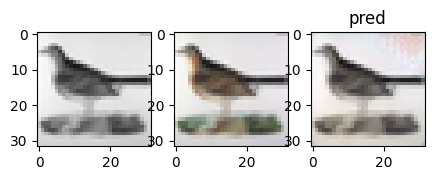

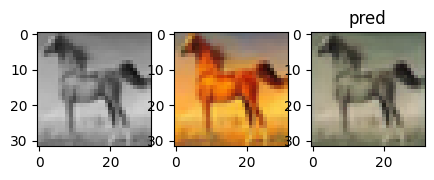

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015232407..1.0643786].


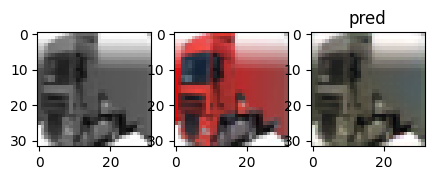

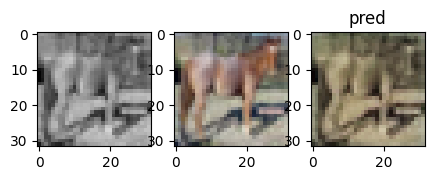

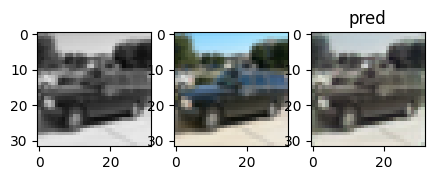

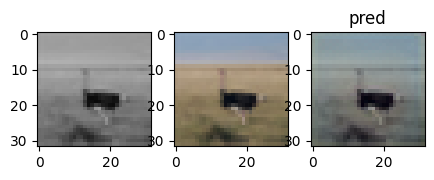

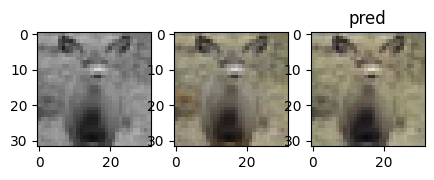

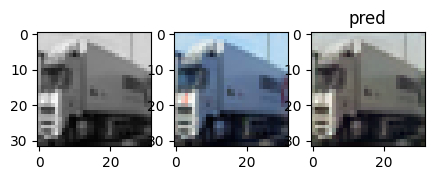

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07071443..1.040167].


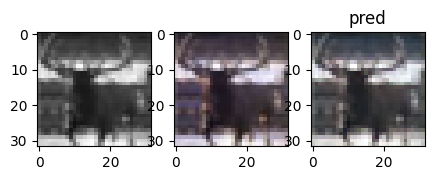

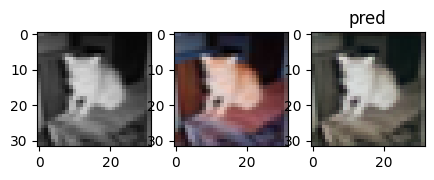

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0022473834..1.206547].


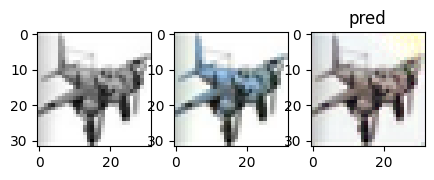

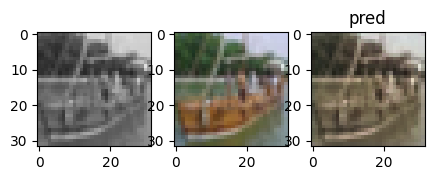

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06770237..0.9609111].


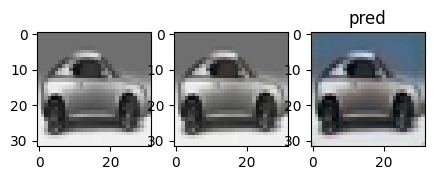

avg: 2/22 Batch 79/79 Loss 0.005050
loss: 0.0055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0064131008..0.96653634].


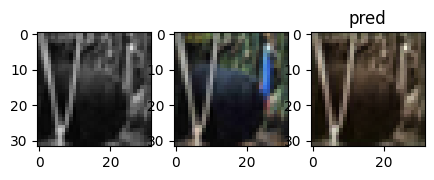

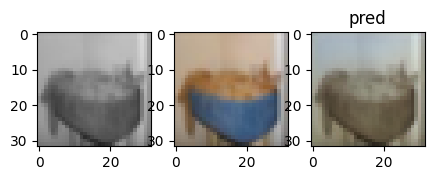

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14768758..1.0111716].


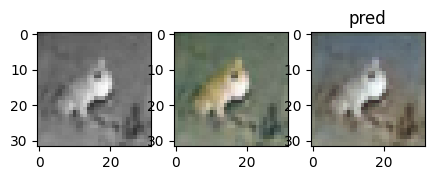

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021611538..1.0372512].


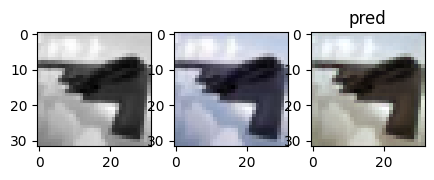

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18258719..1.0205821].


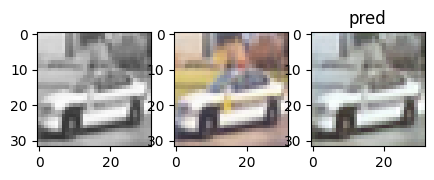

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


model, optimizer, criterion = get_model()
model = model.to(device) # acertar o model certo
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

_val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

n_epochs = 2

for ex in range(n_epochs):
    N = len(trn_dl)

    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        print(f'Epoch {ex+1}/{n_epochs} Batch {bx+1}/{N} Loss {loss:.4f}', end = '\r')

        # validação a cada 50
        if (bx+1) % 50 == 0:
            _val_dl_iter = iter(_val_dl)
            for _ in range(5):
                a, b = next(_val_dl_iter)
                a, b = a.to(device), b.to(device)
                _b = model(a)

                plt.figure(figsize=(5, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(a[0].cpu().numpy().transpose((1, 2, 0)))
                plt.subplot(1, 3, 2)
                plt.imshow(b[0].cpu().numpy().transpose((1, 2, 0)))
                plt.subplot(1, 3, 3)
                plt.imshow(_b[0].cpu().detach().numpy().transpose((1, 2, 0)))
                plt.title("pred")
                plt.show()


    # validação a cada epoca
    val_loss = 0
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        a, b = data
        a, b = a.to(device), b.to(device)

        loss = validate_branch(model, data, criterion)
        val_loss += loss
        print(f'Epoch {ex+1}/{n_epochs} Batch {bx+1}/{N} Loss {loss:.4f}', end = '\r')

    # step do scheduler
    exp_lr_scheduler.step()

    # media da loss de validação
    avg_val_loss = val_loss / N
    print(f'avg: {ex+1}/{n_epochs}\nloss: {avg_val_loss:.4f}')

    _val_dl_iter = iter(_val_dl)

    for _ in range(5):
        a, b = next(_val_dl_iter)
        a, b = a.to(device), b.to(device)
        _b = model(a)

        plt.figure(figsize=(5, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(a[0].cpu().numpy().transpose((1, 2, 0)))
        plt.subplot(1, 3, 2)
        plt.imshow(b[0].cpu().numpy().transpose((1, 2, 0)))
        plt.subplot(1, 3, 3)
        plt.imshow(_b[0].cpu().detach().numpy().transpose((1, 2, 0)))
        plt.title("pred")
        plt.show()
